## Práctica 4 - Procesamiento de audio

Integrantes: Alejandro Bolaños García y David García Díaz

### Ejercicio 1

Construir un identificador de notas musicales. Es decir; en su versión más sencilla (y
suficiente) la entrada es un sonido con una sola nota musical y debe identificar cuál es. Por simplicidad
elija un único instrumento para la identificación

Este primer ejercicio consiste en identificar notas musicales en archivos de audio. Primero, define un diccionario con las frecuencias de notas musicales en varias octavas. La función identificador_nota compara una frecuencia dada con las frecuencias conocidas en el diccionario para identificar la nota y octava correspondientes, aplicando una tolerancia del 5%. Además, el código incluye un filtro pasa banda (función filtro_pasa_banda) para eliminar ruido fuera de un rango de frecuencias especificado. Finalmente, get_frecuencia_sonido lee un archivo de audio, calcula su frecuencia fundamental usando la Transformada Rápida de Fourier (FFT) y llama a identificador_nota para determinar la nota asociada a la frecuencia dominante.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, lfilter, find_peaks
import pyaudio  

In [ ]:
# Diccionario con las frecuencias de las notas musicales en Hz de cada octava por columna 
notas_frecuencias = {
    'Do': [16.3516, 32.7032, 65.4064, 130.813, 261.626, 523.251, 1046.50, 2093.00, 4186.01],
    'Do#': [17.3239, 34.6479, 69.2957, 138.591, 277.183, 554.365, 1108.73, 2217.46, 4434.92],
    'Re': [18.3540, 36.7081, 73.4162, 146.832, 293.665, 587.330, 1174.66, 2349.32, 4698.64],
    'Re#': [19.4454, 38.8909, 77.7817, 155.563, 311.127, 622.254, 1244.51, 2489.02, 4978.04],
    'Mi': [20.6017, 41.2035, 82.4069, 164.814, 329.627, 659.255, 1318.51, 2637.02, 5274.04],
    'Fa': [21.8268, 43.6536, 87.3071, 174.614, 349.228, 698.456, 1396.91, 2793.83, 5587.65],
    'Fa#': [23.1246, 46.2493, 92.4986, 184.997, 369.994, 739.989, 1479.98, 2959.96, 5919.91],
    'Sol': [24.4997, 48.9994, 97.9989, 195.998, 391.995, 783.991, 1567.98, 3135.96, 6271.93],
    'Sol#': [25.9565, 51.9131, 103.826, 207.652, 415.305, 830.609, 1661.22, 3322.44, 6644.88],
    'La': [27.5000, 55.0000, 110.000, 220.000, 440.000, 880.000, 1760.00, 3520.00, 7040.00],
    'La#': [29.1352, 58.2705, 116.541, 233.082, 466.164, 932.328, 1864.66, 3729.31, 7458.62],
    'Si': [30.8677, 61.7354, 123.471, 246.942, 493.883, 987.767, 1975.53, 3951.07, 7902.13]
}

In [ ]:
# Esta función recibe una frecuencia y retorna la nota musical correspondiente.
def identificador_nota(frecuencia):
    tolerancia = 0.05  
    for nota, frecuencias in notas_frecuencias.items():
        for octava, f_hz in enumerate(frecuencias):
            # Comprueba si la frecuencia está dentro del rango de tolerancia de alguna frecuencia de nota
            if (1 - tolerancia) * f_hz < frecuencia < (1 + tolerancia) * f_hz:
                print(f"Nota identificada: {nota} en octava {octava} ({f_hz} Hz)")
                return nota, octava, f_hz
    print(f"Frecuencia {frecuencia} no coincide con ninguna nota.")
    return None


# Función para aplicar un filtro pasa banda a los datos de audio
def filtro_pasa_banda(datos, fs, lowcut=10, highcut=8000, orden=5):
    nyquist = 0.5 * fs  
    low = lowcut / nyquist 
    high = highcut / nyquist 
    b, a = butter(orden, [low, high], btype='band')  
    datos_filtrados = lfilter(b, a, datos) 
    return datos_filtrados


# Función para obtener la frecuencia dominante de un archivo de audio y reconocer la nota
def get_frecuencia_sonido(ruta_archivo):
    
    sample_rate, data = wavfile.read(ruta_archivo)

    # Si el audio es estéreo, selecciona solo un canal (primer canal)
    if len(data.shape) > 1:
        data = data[:, 0]

    N = len(data)
    T = 1.0 / sample_rate  # Calcula el periodo de muestreo

    # Calcula la Transformada Rápida de Fourier (FFT)
    yf = fft(data) 
    xf = fftfreq(N, T)[:N // 2]

    frecuencia_dominante = xf[np.argmax(2.0 / N * np.abs(yf[0:N // 2]))]
    
    identificador_nota(frecuencia_dominante)
    print('Frecuencia fundamental:', frecuencia_dominante, 'Hz\n')

get_frecuencia_sonido("nota_do_c/c4.wav") 
get_frecuencia_sonido("nota_do_c/c6.wav") 
get_frecuencia_sonido("nota_do_c/c7.wav") 
get_frecuencia_sonido("nota_do_c/c8.wav") 


### Aporte adicional
Se trató de crear un programa que identificara en tiempo real la frecuencia de un sonido, de manera que al tocar una tecla del piano identificara su frecuencia a través del micrófono y fuera capaz de señalar de que nota se trataba. Lo cual es una tarea difícil dadas las limitaciones del micrófono pero funciona en su usta medida. Cabe mencionar que para este programa hay dos códigos uno que utiliza la función find_peaks y otro que tan solo busca la frecuencia con mayor amplitud, ambos funcionan correctamente, pero hemos dejado los dos ya que no sabemos si al utilizar un micrófono de calidad existirá alguna diferencia entre ambos.

#### Usando la función find_peaks

In [ ]:

formato = pyaudio.paInt32  # Formato de la muestra, especifica que los datos de audio serán de 32 bits
canales = 1  # Número de canales: 1 para audio mono
tasa_muestreo = 44100  # Frecuencia de muestreo (número de muestras por segundo)
tamano_buffer = 1024  # Cantidad de muestras procesadas en cada captura

p = pyaudio.PyAudio() 

# Función para capturar y procesar audio en tiempo real
def capturar_y_procesar_audio(duracion, n_mayores):
    stream = p.open(format=formato,
                    channels=canales,
                    rate=tasa_muestreo,
                    input=True,
                    frames_per_buffer=tamano_buffer)

    print("Grabando...")

    # Bucle para capturar y procesar el audio durante el tiempo especificado
    for _ in range(0, int(tasa_muestreo / tamano_buffer * duracion)):
        datos = stream.read(tamano_buffer)
        
        datos_np = np.frombuffer(datos, dtype=np.int16)
        
        datos_filtrados = filtro_pasa_banda(datos_np, tasa_muestreo)
        
        N = len(datos_filtrados)
        yf = fft(datos_filtrados)
        xf = fftfreq(N, 1/tasa_muestreo)  # Obtener las frecuencias correspondientes a cada punto en la FFT
        yf_abs = 2.0/N * np.abs(yf[:N//2])  # Calcular la magnitud de la FFT y tomar solo la mitad positiva
        
        umbral_amplitud = 500
        
        # Encontrar los picos significativos en la señal FFT
        picos, propiedades = find_peaks(yf_abs, height=umbral_amplitud, distance=20) 

        if len(picos) > 0:  
            # Ordenar los picos en función de sus amplitudes en orden descendente
            amplitudes_picos = propiedades["peak_heights"]
            indices_ordenados = np.argsort(amplitudes_picos)[::-1]
            
            picos_mayores = picos[indices_ordenados[:n_mayores]]
            
            for pico in picos_mayores:
                frecuencia_sonido = xf[pico]  # Obtener la frecuencia del pico
                identificador_nota(frecuencia_sonido) 
    
    print("Grabación finalizada")
    stream.stop_stream() 
    stream.close()  

capturar_y_procesar_audio(25, 1)

p.terminate() 


#### Detectando tan solo la frecuencia con mayor amplitud

In [ ]:
formato = pyaudio.paInt32  # Formato de la muestra de audio (32-bit)
canales = 1  # Configuración de audio mono
tasa_muestreo = 44100  # Frecuencia de muestreo, en Hz
tamano_buffer = 1024  # Tamaño del buffer para capturar muestras de audio

p = pyaudio.PyAudio()  

# Función para capturar y procesar audio en tiempo real
def capturar_y_procesar_audio(duracion=25):
    stream = p.open(format=formato,
                    channels=canales,
                    rate=tasa_muestreo,
                    input=True,
                    frames_per_buffer=tamano_buffer)

    print("Grabando...")

    # Bucle para capturar y procesar el audio durante el tiempo especificado
    for _ in range(0, int(tasa_muestreo / tamano_buffer * duracion)):
        datos = stream.read(tamano_buffer)
        
        datos_np = np.frombuffer(datos, dtype=np.int16)
        
        datos_filtrados = filtro_pasa_banda(datos_np, tasa_muestreo)
        
        # Procesar los datos de audio usando la Transformada Rápida de Fourier (FFT)
        N = len(datos_filtrados)
        yf = fft(datos_filtrados) 
        xf = fftfreq(N, 1 / tasa_muestreo)  # Calcular las frecuencias correspondientes a cada punto en la FFT
        yf_abs = 2.0 / N * np.abs(yf[:N // 2])  # Obtener la magnitud de la FFT y solo la mitad positiva
        
        # Encontrar el índice de la frecuencia con mayor amplitud en el espectro
        indice_max = np.argmax(yf_abs)
        frecuencia_sonido = xf[indice_max] 
        amplitud_max = yf_abs[indice_max]  

        if amplitud_max > 1000:
            identificador_nota(frecuencia_sonido)  

    print("Grabación finalizada")
    stream.stop_stream() 
    stream.close()  

capturar_y_procesar_audio(25)

p.terminate() 


### Ejercicio 2

Construir una pequeña aplicación que permita operar con diferentes filtros (con un selector)
y trabajar con varios umbrales. (uno para los filtros pasa-bajo y pasa-alto y dos para los filtros pasa-banda
y rechaza-banda). Demuestre su funcionalidad con señales ruidosas. Muestre en cada filtrado la señal
original y filtrada en el dominio temporal y en el dominio de la frecuencia.
(APORTES ADICIONALES)
(a) Reproducir la nota ruidosa filtrada para comparar resultados y cambiar parámetros si es posible.
(b) Aportes adicionales


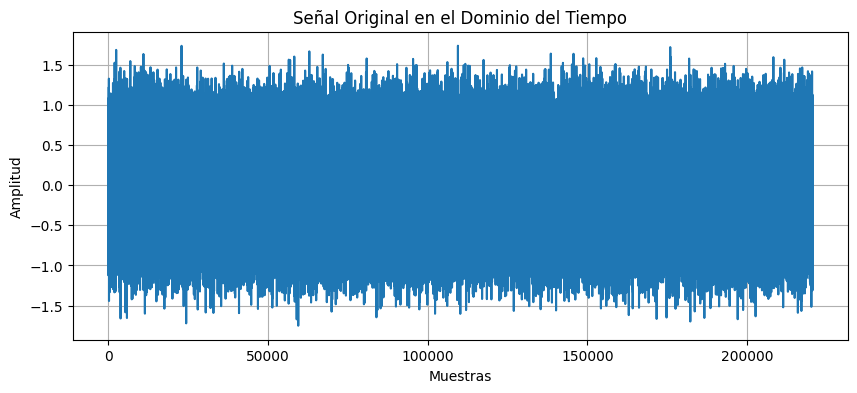

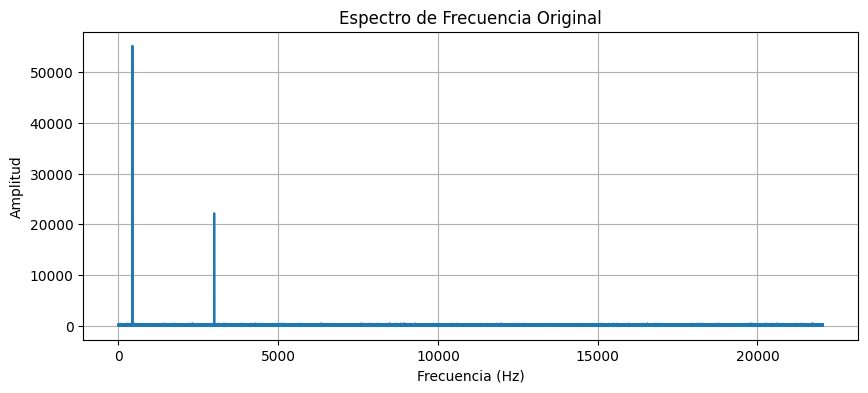

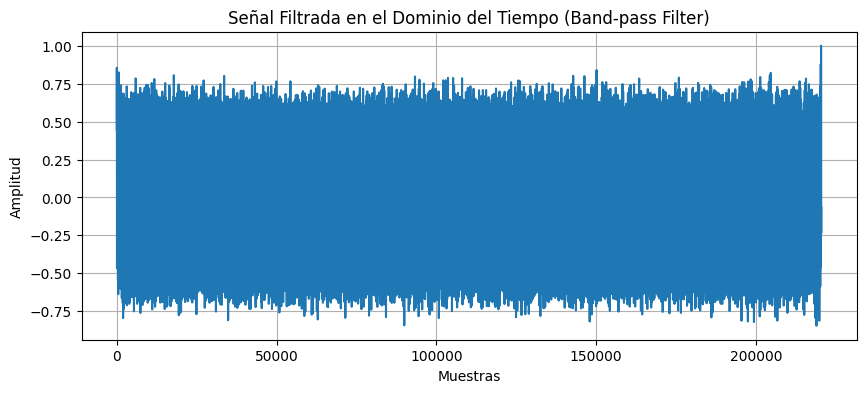

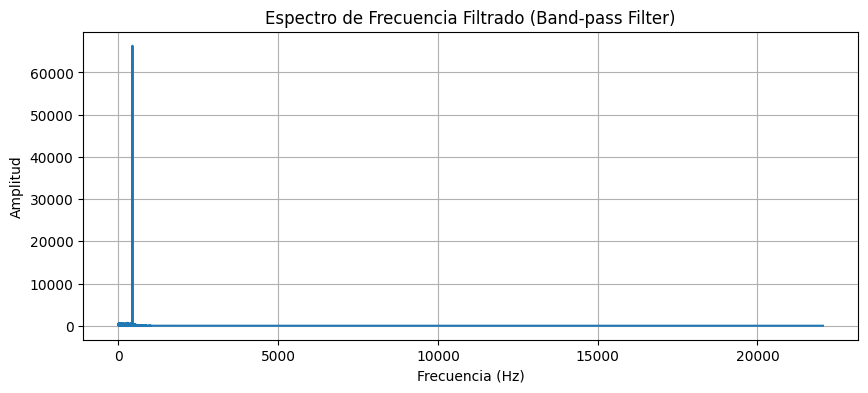

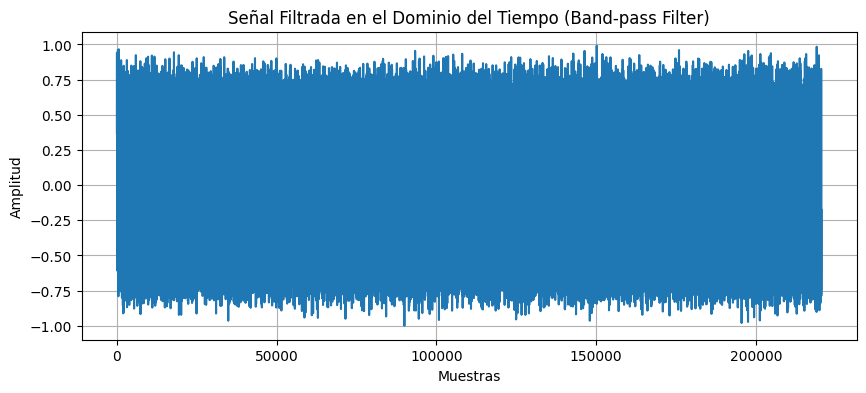

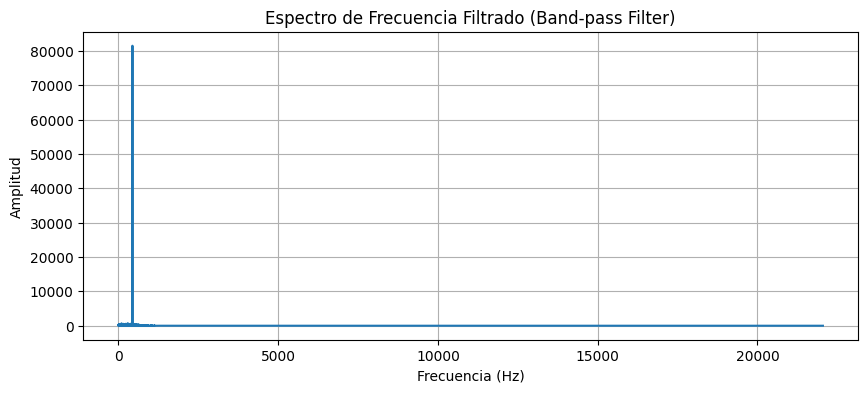

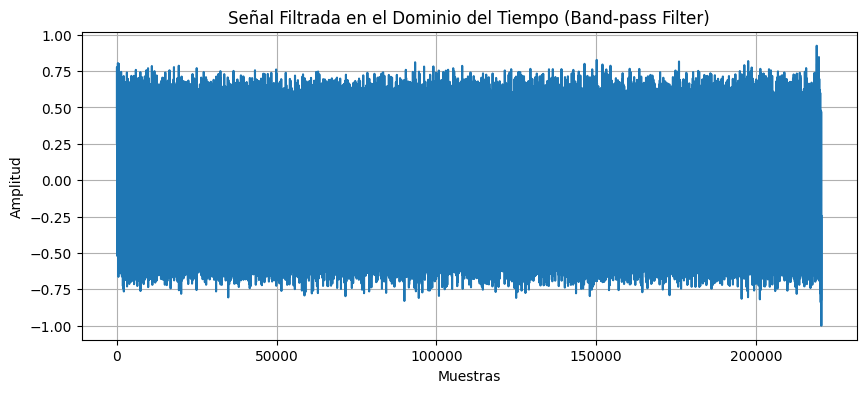

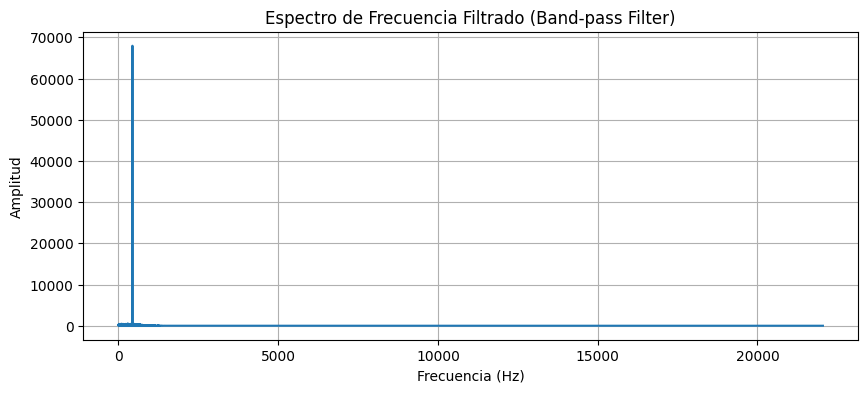

In [8]:
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import sounddevice as sd

# Crear la ventana principal
window = tk.Tk()
window.title("Sound Filters")
window.geometry("500x400")

# Variables globales para las frecuencias de corte
lowcut_var = tk.DoubleVar()
highcut_var = tk.DoubleVar()
cutoff_var = tk.DoubleVar()
filtered_data = None

# Añadir una etiqueta para mostrar el nombre del archivo
filename_label = tk.Label(window, text="No file selected", fg="blue")
filename_label.place(x=205, y=35)

# Función para abrir un archivo de sonido
def open_file():
    file_path = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
    if file_path:
        filename_label.config(text=f"Selected: {file_path.split('/')[-1]}")
        process_sound(file_path)

# Función para guardar el archivo de audio filtrado
def save_filtered_audio(filtered_data, sample_rate):    
    if filtered_data is not None:  # Verifica que los datos filtrados existan
        save_path = filedialog.asksaveasfilename(defaultextension=".wav", filetypes=[("WAV files", "*.wav")])
        if save_path:
            # Escalar los datos filtrados al rango de int16
            scaled_data = np.int16(filtered_data / np.max(np.abs(filtered_data)) * 32767)
            # Guardar el archivo con la escala adecuada
            wavfile.write(save_path, sample_rate, scaled_data)
    else:
        messagebox.showwarning("Error", "No se ha aplicado ningún filtro aún. Por favor, aplique un filtro antes de guardar.")

# Función para reproducir un archivo de sonido
def play_audio(data, sample_rate):
    sd.play(data, samplerate=sample_rate)
    sd.wait()

# Función filtro de paso bajo
def low_pass_filter(data, sample_rate):
    cutoff_freq = cutoff_var.get()
    nyquist = 0.5 * sample_rate
    low = cutoff_freq / nyquist
    b, a = butter(3, low, btype='low')
    filtered_data = filtfilt(b, a, data)
    filtered_data = filtered_data / np.max(np.abs(filtered_data))  # Normalización
    return filtered_data

# Función filtro de paso alto
def high_pass_filter(data, sample_rate):
    cutoff_freq = cutoff_var.get()
    nyquist = 0.5 * sample_rate
    high = cutoff_freq / nyquist
    b, a = butter(3, high, btype='high')
    filtered_data = filtfilt(b, a, data)
    filtered_data = filtered_data / np.max(np.abs(filtered_data))  # Normalización
    return filtered_data

# Función filtro de paso banda
def filtro_pasa_banda(data, sample_rate):
    lowcut_freq = lowcut_var.get()
    highcut_freq = highcut_var.get()
    if lowcut_freq >= highcut_freq:
        messagebox.showwarning("Error", "La frecuencia de corte inferior debe ser menor que la frecuencia de corte superior.")
        return data
    nyquist = 0.5 * sample_rate
    low = lowcut_freq / nyquist
    high = highcut_freq / nyquist
    b, a = butter(3, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    filtered_data = filtered_data / np.max(np.abs(filtered_data))  # Normalización
    return filtered_data

# Función filtro rechaza banda
def filtro_rechaza_banda(data, sample_rate):
    lowcut_freq = lowcut_var.get()
    highcut_freq = highcut_var.get()
    if lowcut_freq >= highcut_freq:
        messagebox.showwarning("Error", "La frecuencia de corte inferior debe ser menor que la frecuencia de corte superior.")
        return data
    nyquist = 0.5 * sample_rate
    low = lowcut_freq / nyquist
    high = highcut_freq / nyquist
    b, a = butter(3, [low, high], btype='bandstop')
    filtered_data = filtfilt(b, a, data)
    filtered_data = filtered_data / np.max(np.abs(filtered_data))  # Normalización
    return filtered_data

# Función para procesar el archivo de sonido
def process_sound(file_path):
    sample_rate, data = wavfile.read(file_path)
    
    # Si es estéreo, convertirlo a mono tomando un solo canal
    if len(data.shape) == 2:
        data = data[:, 0]
    
    # Reproducir el audio original
    play_audio(data, sample_rate)
    
    # Mostrar la señal original en el dominio del tiempo
    plt.figure(figsize=(10, 4))
    plt.plot(data)
    plt.title("Señal Original en el Dominio del Tiempo")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

    # Aplicar la FFT para ver el espectro de frecuencias
    N = len(data)
    T = 1.0 / sample_rate
    yf = np.fft.fft(data)
    xf = np.fft.fftfreq(N, T)[:N // 2]
    
    # Mostrar el espectro de frecuencias original
    plt.figure(figsize=(10, 4))
    plt.plot(xf, np.abs(yf[:N // 2]))
    plt.title("Espectro de Frecuencia Original")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

    # Función para aplicar el filtro seleccionado
    def apply_filter():
        global filtered_data
        selected_filter = filter_var.get()

        if selected_filter == "Band-pass Filter":
            filtered_data = filtro_pasa_banda(data, sample_rate)
        elif selected_filter == "High-pass Filter":
            filtered_data = high_pass_filter(data, sample_rate)
        elif selected_filter == "Low-pass Filter":
            filtered_data = low_pass_filter(data, sample_rate)
        elif selected_filter == "Band-stop Filter":
            filtered_data = filtro_rechaza_banda(data, sample_rate)

        # Reproducir el audio filtrado
        play_audio(filtered_data, sample_rate)

        # Mostrar la señal filtrada en el dominio del tiempo
        plt.figure(figsize=(10, 4))
        plt.plot(filtered_data)
        plt.title(f"Señal Filtrada en el Dominio del Tiempo ({selected_filter})")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()

        # Aplicar la FFT para ver el espectro de frecuencias
        N = len(filtered_data)
        T = 1.0 / sample_rate
        yf = np.fft.fft(filtered_data)
        xf = np.fft.fftfreq(N, T)[:N // 2]
        
        # Mostrar el espectro de frecuencias filtrado
        plt.figure(figsize=(10, 4))
        plt.plot(xf, np.abs(yf[:N // 2]))
        plt.title(f"Espectro de Frecuencia Filtrado ({selected_filter})")
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()

    # Botón para aplicar el filtro
    apply_button = tk.Button(window, text="Apply Filter", command=apply_filter)
    apply_button.place(x=220, y=300)

    # Botón para guardar el audio filtrado
    save_button = tk.Button(window, text="Guardar Audio Filtrado", command=lambda: save_filtered_audio(filtered_data, sample_rate))
    save_button.place(x=220, y=330)    

# Crear el menú desplegable para seleccionar el filtro
filter_var = tk.StringVar(window)
filter_var.set("Select a Filter")
filter_dropdown = tk.OptionMenu(window, filter_var, "High-pass Filter", "Low-pass Filter", "Band-pass Filter", "Band-stop Filter")
filter_dropdown.place(x=200, y=55)

# Crear trackbars para ajustar la frecuencia de corte
cutoff_scale = tk.Scale(window, from_=10, to=20000, resolution=1, orient='horizontal', label='Frecuencia de corte (Hz)', variable=cutoff_var)
cutoff_scale.place(x=160, y=90, width=200)

# Crear trackbars para filtro de paso banda (lowcut y highcut)
lowcut_scale = tk.Scale(window, from_=10, to=20000, resolution=1, orient='horizontal', label='Low-cut (Hz)', variable=lowcut_var)
lowcut_scale.place(x=160, y=150, width=200)
highcut_scale = tk.Scale(window, from_=10, to=20000, resolution=1, orient='horizontal', label='High-cut (Hz)', variable=highcut_var)
highcut_scale.place(x=160, y=210, width=200)

# Botón para abrir un archivo de sonido
open_button = tk.Button(window, text="Open Sound File", command=open_file)
open_button.place(x=205, y=10)

# Iniciar el loop principal
window.mainloop()


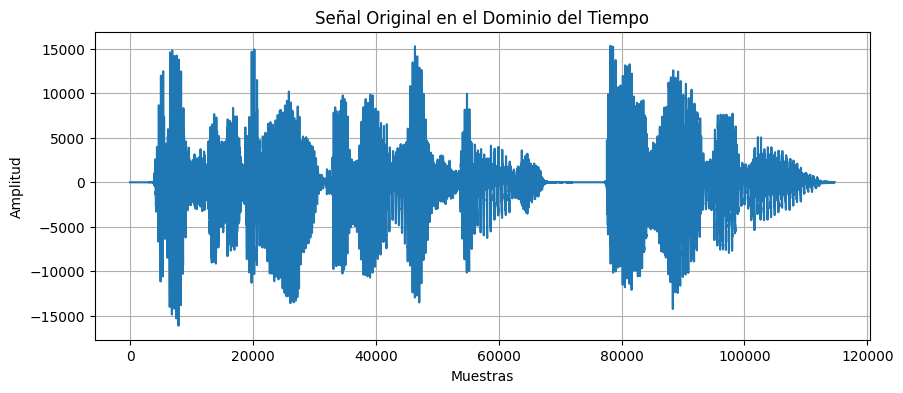

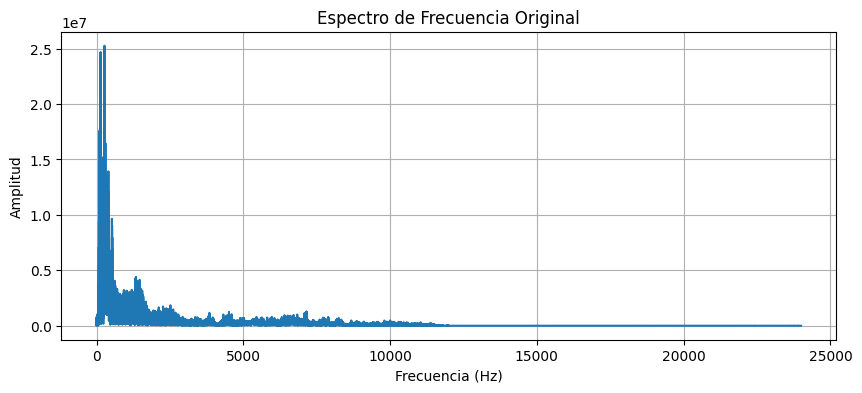

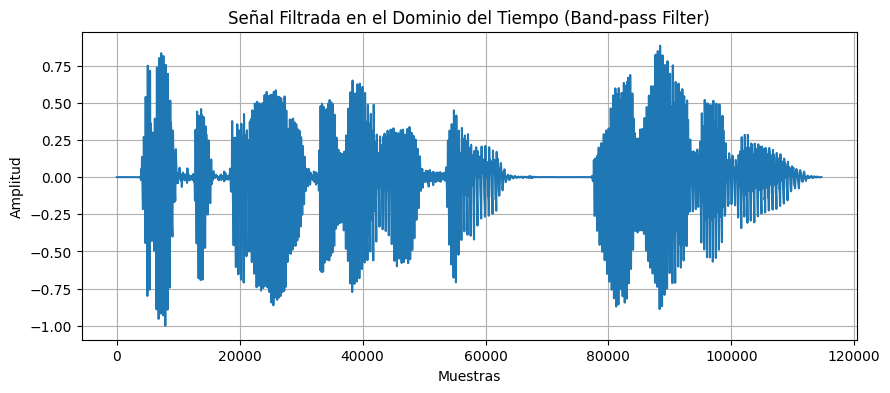

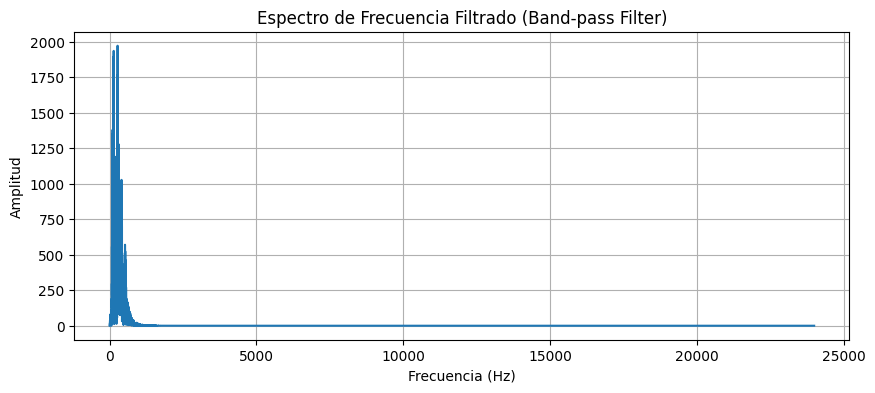

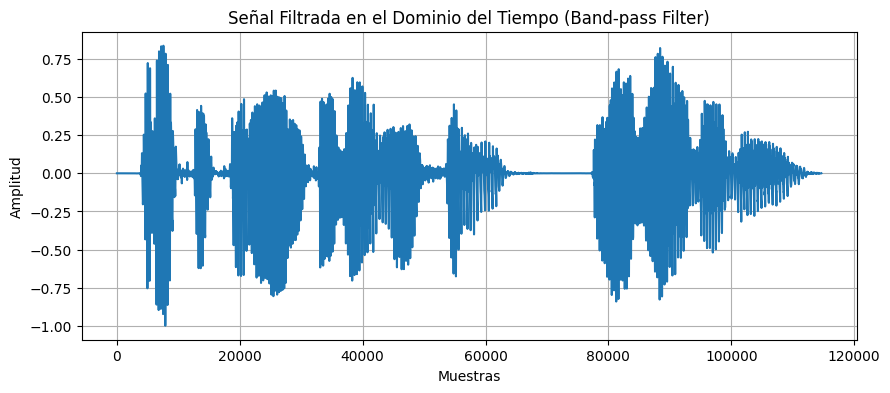

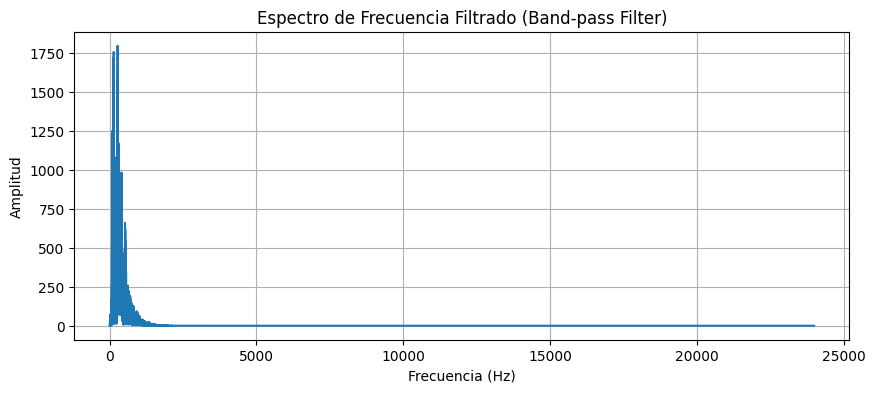

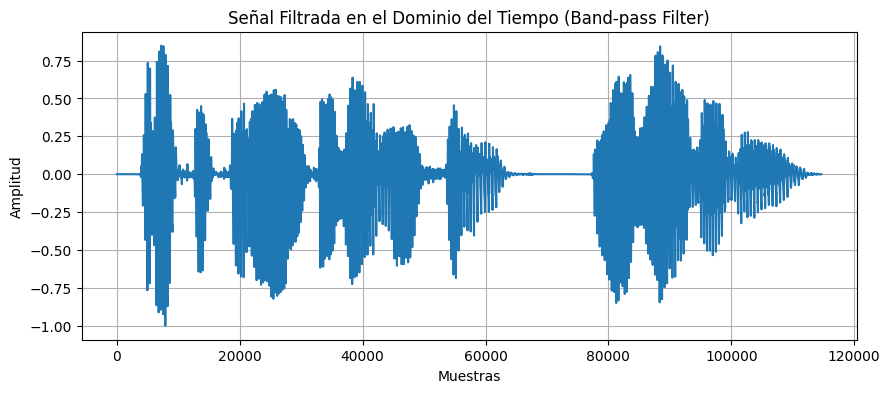

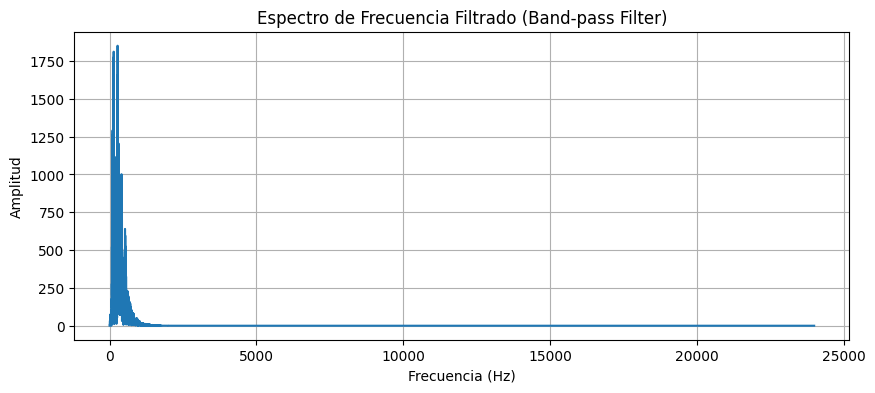

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import sounddevice as sd

# Crear la ventana principal
window = tk.Tk()
window.title("Sound Filters")
window.geometry("500x400")

# Variables globales para las frecuencias de corte
lowcut_var = tk.DoubleVar()
highcut_var = tk.DoubleVar()
cutoff_var = tk.DoubleVar()
filtered_data = None
original_data = None
sample_rate = None

# Añadir una etiqueta para mostrar el nombre del archivo
filename_label = tk.Label(window, text="No file selected", fg="blue")
filename_label.place(x=205, y=35)

# Función para abrir un archivo de sonido
def open_file():
    global original_data, sample_rate
    file_path = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
    if file_path:
        filename_label.config(text=f"Selected: {file_path.split('/')[-1]}")
        sample_rate, original_data = wavfile.read(file_path)
        if original_data.ndim == 2:  # Convertir estéreo a mono si es necesario
            original_data = original_data[:, 0]
        process_sound()

# Función para guardar el archivo de audio filtrado
def save_filtered_audio(filtered_data, sample_rate):    
    if filtered_data is not None:  # Verifica que los datos filtrados existan
        save_path = filedialog.asksaveasfilename(defaultextension=".wav", filetypes=[("WAV files", "*.wav")])
        if save_path:
            # Escalar los datos filtrados al rango de int16
            scaled_data = np.int16(filtered_data / np.max(np.abs(filtered_data)) * 32767)
            # Guardar el archivo con la escala adecuada
            wavfile.write(save_path, sample_rate, scaled_data)
    else:
        messagebox.showwarning("Error", "No se ha aplicado ningún filtro aún. Por favor, aplique un filtro antes de guardar.")

# Función para reproducir un archivo de sonido
def play_audio(data, sample_rate):
    if data is not None:
        sd.play(data, samplerate=sample_rate)
    else:
        messagebox.showwarning("Error", "No se ha seleccionado ningún archivo de sonido.")

# Función para detener el audio
def stop_audio():
    sd.stop()

# Función filtro de paso bajo
def low_pass_filter(data, sample_rate):
    cutoff_freq = cutoff_var.get()
    nyquist = 0.5 * sample_rate
    low = cutoff_freq / nyquist
    b, a = butter(3, low, btype='low')
    filtered_data = filtfilt(b, a, data)
    filtered_data = filtered_data / np.max(np.abs(filtered_data))  # Normalización
    return filtered_data

# Función filtro de paso alto
def high_pass_filter(data, sample_rate):
    cutoff_freq = cutoff_var.get()
    nyquist = 0.5 * sample_rate
    high = cutoff_freq / nyquist
    b, a = butter(3, high, btype='high')
    filtered_data = filtfilt(b, a, data)
    filtered_data = filtered_data / np.max(np.abs(filtered_data))  # Normalización
    return filtered_data

# Función filtro de paso banda
def filtro_pasa_banda(data, sample_rate):
    lowcut_freq = lowcut_var.get()
    highcut_freq = highcut_var.get()
    if lowcut_freq >= highcut_freq:
        messagebox.showwarning("Error", "La frecuencia de corte inferior debe ser menor que la frecuencia de corte superior.")
        return data
    nyquist = 0.5 * sample_rate
    low = lowcut_freq / nyquist
    high = highcut_freq / nyquist
    b, a = butter(3, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    filtered_data = filtered_data / np.max(np.abs(filtered_data))  # Normalización
    return filtered_data

# Función filtro rechaza banda
def filtro_rechaza_banda(data, sample_rate):
    lowcut_freq = lowcut_var.get()
    highcut_freq = highcut_var.get()
    if lowcut_freq >= highcut_freq:
        messagebox.showwarning("Error", "La frecuencia de corte inferior debe ser menor que la frecuencia de corte superior.")
        return data
    nyquist = 0.5 * sample_rate
    low = lowcut_freq / nyquist
    high = highcut_freq / nyquist
    b, a = butter(3, [low, high], btype='bandstop')
    filtered_data = filtfilt(b, a, data)
    filtered_data = filtered_data / np.max(np.abs(filtered_data))  # Normalización
    return filtered_data

# Función para procesar el archivo de sonido
def process_sound():
    global filtered_data

    # Mostrar la señal original en el dominio del tiempo
    plt.figure(figsize=(10, 4))
    plt.plot(original_data)
    plt.title("Señal Original en el Dominio del Tiempo")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

    # Aplicar la FFT para ver el espectro de frecuencias
    N = len(original_data)
    T = 1.0 / sample_rate
    yf = np.fft.fft(original_data)
    xf = np.fft.fftfreq(N, T)[:N // 2]
    
    # Mostrar el espectro de frecuencias original
    plt.figure(figsize=(10, 4))
    plt.plot(xf, np.abs(yf[:N // 2]))
    plt.title("Espectro de Frecuencia Original")
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Amplitud")
    plt.grid()
    plt.show()

    # Función para aplicar el filtro seleccionado
    def apply_filter():
        global filtered_data
        selected_filter = filter_var.get()

        if selected_filter == "Band-pass Filter":
            filtered_data = filtro_pasa_banda(original_data, sample_rate)
        elif selected_filter == "High-pass Filter":
            filtered_data = high_pass_filter(original_data, sample_rate)
        elif selected_filter == "Low-pass Filter":
            filtered_data = low_pass_filter(original_data, sample_rate)
        elif selected_filter == "Band-stop Filter":
            filtered_data = filtro_rechaza_banda(original_data, sample_rate)

        # Reproducir el audio filtrado
        play_audio(filtered_data, sample_rate)

        # Mostrar la señal filtrada en el dominio del tiempo
        plt.figure(figsize=(10, 4))
        plt.plot(filtered_data)
        plt.title(f"Señal Filtrada en el Dominio del Tiempo ({selected_filter})")
        plt.xlabel("Muestras")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()

        # Aplicar la FFT para ver el espectro de frecuencias
        N = len(filtered_data)
        T = 1.0 / sample_rate
        yf = np.fft.fft(filtered_data)
        xf = np.fft.fftfreq(N, T)[:N // 2]
        
        # Mostrar el espectro de frecuencias filtrado
        plt.figure(figsize=(10, 4))
        plt.plot(xf, np.abs(yf[:N // 2]))
        plt.title(f"Espectro de Frecuencia Filtrado ({selected_filter})")
        plt.xlabel("Frecuencia (Hz)")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()

    # Botón para aplicar el filtro
    apply_button = tk.Button(window, text="Apply Filter", command=apply_filter)
    apply_button.place(x=220, y=300)

    # Botón para guardar el audio filtrado
    save_button = tk.Button(window, text="Guardar Audio Filtrado", command=lambda: save_filtered_audio(filtered_data, sample_rate))
    save_button.place(x=220, y=330)    

# Crear el menú desplegable para seleccionar el filtro
filter_var = tk.StringVar(window)
filter_var.set("Select a Filter")
filter_dropdown = tk.OptionMenu(window, filter_var, "High-pass Filter", "Low-pass Filter", "Band-pass Filter", "Band-stop Filter")
filter_dropdown.place(x=200, y=55)

# Crear trackbars para ajustar la frecuencia de corte
cutoff_scale = tk.Scale(window, from_=10, to=20000, resolution=1, orient='horizontal', label='Frecuencia de corte (Hz)', variable=cutoff_var)
cutoff_scale.place(x=160, y=90, width=200)

# Crear trackbars para filtro de paso banda (lowcut y highcut)
lowcut_scale = tk.Scale(window, from_=10, to=20000, resolution=1, orient='horizontal', label='Low-cut (Hz)', variable=lowcut_var)
lowcut_scale.place(x=160, y=150, width=200)
highcut_scale = tk.Scale(window, from_=10, to=20000, resolution=1, orient='horizontal', label='High-cut (Hz)', variable=highcut_var)
highcut_scale.place(x=160, y=210, width=200)

# Botón para abrir un archivo de sonido
open_button = tk.Button(window, text="Open Sound File", command=open_file)
open_button.place(x=205, y=10)

# Botón para reproducir el audio original
play_button = tk.Button(window, text="Play Original Audio", command=lambda: play_audio(original_data, sample_rate))
play_button.place(x=100, y=270)

# Botón para detener el audio
stop_button = tk.Button(window, text="Stop Audio", command=stop_audio)
stop_button.place(x=300, y=270)

# Iniciar el loop principal
window.mainloop()
